In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
import openpyxl

import pymc as pm
import arviz as az
import stan
import aesara.tensor as at
import nest_asyncio

from scipy.special import ndtri
from scipy.stats import norm, lognorm
from scipy.optimize import minimize

from sklearn.metrics import roc_auc_score

import time

from utils import stan_wrapper, stan_visualize_out, stan_predict, \
    pymc_wrapper, pymc_predict, MLS_wrapper, minimize_predict

In [2]:
FACTOR = 1
beta   = 0.88



mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export


THETA_INIT = 0.42
LAMBDA_INIT = 1.6
TAU_INIT = .28
ALPHA_INIT = .9
GAMMA_INIT = .7
ERROR_INIT = 0


INIT_VALUES = np.array([THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT])



In [4]:
data_dir    = '/Users/administrator/MGME/Sandbox/Clustering project/Gallup'

if 0:
    fname       = os.path.join(data_dir,'activation_codes.csv')
    activation_codes = pd.read_csv(fname)
    activation_codes.head()

    df_gallup = pd.DataFrame()


    raw_data_excluding_gaze = {}
    counter     = 0
    location    = os.path.join(data_dir,'additional_data')
    fname       = 'combined_data.json'

    for folder in activation_codes['activation_code']:
        counter += 1
        print(f'Processing subject {counter} of {len(activation_codes)}: {folder}')
        
        # Load the JSON data for the current subject
        with open(os.path.join(location, folder, fname), 'r') as file:
            data = json.load(file)
            # Check the keys in the data
            print(data['dm_decision1'].keys())
            # Create DataFrame from dm_decision1
            df_local = pd.DataFrame(data['dm_decision1'])
            # Rename columns as an example
            df_local = df_local.rename(columns={
                'probability_win_percent': 'prob_win',
                'probability_loss_percent': 'prob_loss',
                'potential_gain': 'gain',
                'potential_loss': 'loss'
            })
            df_local['prob_win'] = df_local['prob_win'] / 100
            df_local['prob_loss'] = df_local['prob_loss'] / 100
            
            
            # Repeat the activation_codes row for this subject for each row in df_local
            activation_row = activation_codes.loc[activation_codes['activation_code'] == folder].iloc[0]
            for col in activation_codes.columns:
                df_local[col] = activation_row[col]

            # Optionally reset index if you want a clean DataFrame
            df_local = df_local.reset_index(drop=True)
            df_local = df_local.rename(columns={
                'activation_code': 'subject'    })
            
            df_local = df_local[['subject'] + [col for col in df_local.columns if col != 'subject']]
            
            df_gallup = pd.concat([df_gallup, df_local], ignore_index=True)
            
            
    correct_probs = pd.read_excel(os.path.join(data_dir, 'decision_making_004_50Trials_self.xlsx'), sheet_name='trials')
    df_gallup['prob_win'] = np.tile(correct_probs['probability_win_percent'].values / 100, 350)
    df_gallup['prob_ambi'] = 1 - df_gallup['prob_win'] - df_gallup['prob_loss']

else:

    df_gallup = pd.read_csv(os.path.join(data_dir, 'df_gallup.csv'))

In [5]:
df_gallup

,subject,prob_win,prob_loss,gain,loss,invest,task_onset_at,user_answered_at,Unnamed: 0,Invite Email,participant_ID,prob_ambi
0,ef08e1a4-206d-4262-b649-1efa62d73134,0.5,0.0,100,80,1,1.735841e+09,1.735841e+09,0,Order1_00374@gallup.com,Order1_00374@gallup.com,0.5
1,ef08e1a4-206d-4262-b649-1efa62d73134,0.1,0.2,60,40,1,1.735841e+09,1.735841e+09,0,Order1_00374@gallup.com,Order1_00374@gallup.com,0.7
2,ef08e1a4-206d-4262-b649-1efa62d73134,0.4,0.5,100,30,0,1.735841e+09,1.735841e+09,0,Order1_00374@gallup.com,Order1_00374@gallup.com,0.1
3,ef08e1a4-206d-4262-b649-1efa62d73134,0.1,0.3,50,20,0,1.735841e+09,1.735841e+09,0,Order1_00374@gallup.com,Order1_00374@gallup.com,0.6
4,ef08e1a4-206d-4262-b649-1efa62d73134,0.5,0.5,70,70,0,1.735841e+09,1.735841e+09,0,Order1_00374@gallup.com,Order1_00374@gallup.com,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17495,4d1cff36-ad3e-4126-bd33-156278891963,0.3,0.5,70,30,1,1.739563e+09,1.739563e+09,349,Order70_69904@gallup.com,Order70_69904@gallup.com,0.2
17496,4d1cff36-ad3e-4126-bd33-156278891963,0.7,0.1,50,100,1,1.739563e+09,1.739563e+09,349,Order70_69904@gallup.com,Order70_69904@gallup.com,0.2
17497,4d1cff36-ad3e-4126-bd33-156278891963,0.4,0.2,90,90,1,1.739563e+09,1.739563e+09,349,Order70_69904@gallup.com,Order70_69904@gallup.com,0.4
17498,4d1cff36-ad3e-4126-bd33-156278891963,0.3,0.7,40,10,0,1.739563e+09,1.739563e+09,349,Order70_69904@gallup.com,Order70_69904@gallup.com,0.0


In [ ]:
from IPython.display import clear_output

if 'auc_results' in locals():
    del auc_results
    
# Prepare a DataFrame to store AUC scores and fitting times for each subject
subjects = df_gallup.subject.unique()
auc_results = pd.DataFrame(
    index=subjects,
    columns=[
        'roc_auc_stan', 
        # 'roc_auc_pymc', 
        'roc_auc_MLS',
        'stan_time', 
        # 'pymc_time', 
        'MLS_time'
    ]
)
params_stan = pd.DataFrame()
params_MLS = pd.DataFrame()


subj_counter = 1
for subject in subjects[:10]:
    clear_output(wait=True)
    print(f"Processing subject {subj_counter}/{len(subjects)}...")
    df_subj = df_gallup[df_gallup['subject'] == subject].copy()
    df_subj['invest'] = df_subj['invest'].astype(int)

    # Stan
    start_time_stan = time.time()
    stan_fit_subj   = stan_wrapper(df_subj, x0, INIT_VALUES=INIT_VALUES, FACTOR=FACTOR, beta=beta)
    stan_time_subj  = time.time() - start_time_stan
    stan_pred       = stan_predict(stan_fit_subj, df_subj, FACTOR=FACTOR)
    stan_params_subj = {
        'subject': subject,
        'theta': stan_fit_subj.to_frame()['theta'].mean(),
        'Lambda': stan_fit_subj.to_frame()['Lambda'].mean(),
        'alpha': stan_fit_subj.to_frame()['alpha'].mean(),
        'tau': stan_fit_subj.to_frame()['tau'].mean(),
        'beta': 0.88,  # already defined as 0.88
        'gamma': stan_fit_subj.to_frame()['gamma'].mean(),
        'error': stan_fit_subj.to_frame()['error'].mean()
    }

    params_stan = pd.concat([params_stan, pd.DataFrame(stan_params_subj, index=[0])], axis=0)
    

    # # PyMC
    # start_time_pymc = time.time()
    # trace_subj = pymc_wrapper(df_subj, distro_estimates, INIT_VALUES, FACTOR=FACTOR, beta=beta, energy_plot_flag=False, distri_plot_flag=False)
    # pymc_time_subj = time.time() - start_time_pymc
    # pymc_pred = pymc_predict(trace_subj, df_subj, FACTOR=FACTOR, beta=beta)

    # MLS
    start_time_MLS = time.time()
    estimates_subj = MLS_wrapper(df_subj, INIT_VALUES, distro_estimates)
    MLS_time_subj  = time.time() - start_time_MLS
    MLS_pred       = minimize_predict(estimates_subj, df_subj, FACTOR=FACTOR, beta=beta)
    theta, Lambda, tau, alpha, gamma, error = estimates_subj.x
    MLS_params_subj = {
        'subject': subject,
        'theta': theta,
        'Lambda': Lambda,
        'alpha': alpha,
        'tau': tau,
        'beta': 0.88,  # already defined as 0.88
        'gamma': gamma,
        'error': error
    }
    params_MLS = pd.concat([params_MLS, pd.DataFrame(MLS_params_subj, index=[0])], axis=0)                           
    y_true_subj = df_subj['invest'].values

    auc_results.loc[subject, 'roc_auc_stan'] = roc_auc_score(y_true_subj, stan_pred)
    # auc_results.loc[subject, 'roc_auc_pymc'] = roc_auc_score(y_true_subj, pymc_pred)
    auc_results.loc[subject, 'roc_auc_MLS'] = roc_auc_score(y_true_subj, MLS_pred)
    auc_results.loc[subject, 'stan_time'] = stan_time_subj
    # auc_results.loc[subject, 'pymc_time'] = pymc_time_subj
    auc_results.loc[subject, 'MLS_time'] = MLS_time_subj
    
    subj_counter += 1
    
auc_results.to_csv('auc_results_by_subject.csv')
auc_results


Processing subject 7/350...
Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   5% (400/8000)
Sampling:   9% (700/8000)
Sampling:  15% (1200/8000)
Sampling:  39% (3100/8000)
Sampling:  60% (4800/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampli

In [ ]:
if 0:
    
    def minimize_predict(estimates, df, FACTOR=1, beta=0.88):
        """
        Function to predict using the PyMC model trace.
        """
        # Extract the mean of the posterior samples for each parameter
        theta, Lambda, tau, alpha, gamma, error = estimates.x
            

        predictions = []
        intermidiate_values = pd.DataFrame(columns=['subj_gain', 'subj_prob_g', 'subj_loss', 'subj_prob_l', 'p_invest'])

        for _, row in df.iterrows():
            gain = row['gain'] * FACTOR
            loss = row['loss'] * FACTOR 
            prob_win = row['prob_win']
            prob_loss = row['prob_loss']
            prob_ambi = row['prob_ambi']

            def np_calc_subj_values(x, Lambda, alpha, beta):
                return x**alpha if x >= 0 else -Lambda * ((-x)**beta)

            def np_calc_eta(green, red, theta, prob_ambi):
                return green + prob_ambi * theta

            def np_calc_subj_prob(prob, gamma):
                return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)


            prob_g = np.clip(np_calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
            prob_l = np.clip(np_calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)
            
            subj_gain = np_calc_subj_values(gain, Lambda, alpha, beta)
            subj_loss = np_calc_subj_values(loss, Lambda, alpha, beta)
            subj_prob_g = np_calc_subj_prob(prob_g, gamma)
            subj_prob_l = np_calc_subj_prob(prob_l, gamma)
            utility = subj_gain * subj_prob_g + subj_loss * subj_prob_l

            # Probability to invest
            p_invest = 1 / (1 + np.exp(-tau * (utility - error)))
            
            intermidiate_values = pd.concat([intermidiate_values, pd.DataFrame({
                'subj_gain': [subj_gain],
                'subj_prob_g': [subj_prob_g],
                'subj_loss': [subj_loss],
                'prob_loss': [prob_loss],
                'subj_prob_l': [subj_prob_l],
                'p_invest': [p_invest]
            })], ignore_index=True)

            # Predict invest = 1 if p_invest > 0.5, else 0
            invest_pred = int(p_invest > 0.5)
            predictions.append(invest_pred)
            

        return predictions, intermidiate_values



    def stan_predict(stan_fit, df, FACTOR=1):
        """
        Function to predict using the Stan model.
        """
        # Extract the mean of the posterior samples for each parameter
        theta = stan_fit.to_frame()['theta'].mean()
        Lambda = stan_fit.to_frame()['Lambda'].mean()
        alpha = stan_fit.to_frame()['alpha'].mean()
        tau = stan_fit.to_frame()['tau'].mean()
        beta = 0.88  # already defined as 0.88
        gamma = stan_fit.to_frame()['gamma'].mean()
        error = stan_fit.to_frame()['error'].mean()

        predictions = []
        intermidiate_values = pd.DataFrame(columns=['subj_gain', 'subj_prob_g', 'subj_loss', 'subj_prob_l', 'p_invest'])


        for _, row in df.iterrows():
            gain = row['gain'] * FACTOR
            loss = row['loss'] * FACTOR 
            prob_win = row['prob_win']
            prob_loss = row['prob_loss']
            prob_ambi = row['prob_ambi']

            # Calculate subjective probabilities and values using numpy
            def np_calc_subj_values(x, Lambda, alpha, beta):
                return x**alpha if x >= 0 else -Lambda * ((-x)**beta)

            def np_calc_eta(green, red, theta, prob_ambi):
                return green + prob_ambi * theta

            def np_calc_subj_prob(prob, gamma):
                return prob**gamma / (prob**gamma + (1 - prob)**gamma)**(1/gamma)

            prob_g = np.clip(np_calc_eta(prob_win, prob_loss, theta, prob_ambi), 0, 1)
            prob_l = np.clip(np_calc_eta(prob_loss, prob_win, 1-theta, prob_ambi), 0, 1)

            subj_gain = np_calc_subj_values(gain, Lambda, alpha, beta)
            subj_loss = np_calc_subj_values(loss, Lambda, alpha, beta)
            subj_prob_g = np_calc_subj_prob(prob_g, gamma)
            subj_prob_l = np_calc_subj_prob(prob_l, gamma)
            utility = subj_gain * subj_prob_g + subj_loss * subj_prob_l

            # Probability to invest
            p_invest = 1 / (1 + np.exp(-tau * (utility - error)))
            
            

            intermidiate_values = pd.concat([intermidiate_values, pd.DataFrame({
                'subj_gain': [subj_gain],
                'subj_prob_g': [subj_prob_g],
                'subj_loss': [subj_loss],
                'prob_loss': [prob_loss],
                'subj_prob_l': [subj_prob_l],
                'p_invest': [p_invest]
            })], ignore_index=True)

            # Predict invest = 1 if p_invest > 0.5, else 0
            invest_pred = int(p_invest > 0.5)
            predictions.append(invest_pred)
            

        return predictions, intermidiate_values

In [79]:
MLS_pred, intermidiate_values_MLS      = minimize_predict(estimates_subj, df_subj, FACTOR=FACTOR, beta=beta)
stan_pred, intermidiate_values_stan      = stan_predict(stan_fit_subj, df_subj, FACTOR=FACTOR)



/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_17942/272681600.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  intermidiate_values = pd.concat([intermidiate_values, pd.DataFrame({
/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_17942/272681600.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  intermidiate_values = pd.concat([intermidiate_values, pd.DataFrame({


In [78]:
theta, Lambda, tau, alpha, gamma, error = estimates_subj.x
estimates_subj.x

array([0.255     , 0.90937051, 0.2486513 , 0.77805203, 0.61806157,
       1.09033954])

In [82]:
estimates_subj

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 30.543359524793008
             x: [ 2.550e-01  9.094e-01  2.487e-01  7.781e-01  6.181e-01
                  1.090e+00]
           nit: 1605
          nfev: 2540
 final_simplex: (array([[ 2.550e-01,  9.094e-01, ...,  6.181e-01,
                         1.090e+00],
                       [ 2.550e-01,  9.094e-01, ...,  6.181e-01,
                         1.090e+00],
                       ...,
                       [ 2.550e-01,  9.094e-01, ...,  6.181e-01,
                         1.090e+00],
                       [ 2.550e-01,  9.094e-01, ...,  6.181e-01,
                         1.090e+00]]), array([ 3.054e+01,  3.054e+01,  3.054e+01,  3.054e+01,
                        3.054e+01,  3.054e+01,  3.054e+01]))

In [77]:
stan_params_subj

{'subject': '0bb0dbb9-2b21-4ab7-bbc9-143ff545ae4a',
 'theta': 0.3886920466896704,
 'Lambda': 1.897188708625003,
 'alpha': 0.7813280409080061,
 'tau': 0.2774935681559859,
 'beta': 0.88,
 'gamma': 3.9583060192566673,
 'error': 4.02458636451205}

In [80]:
intermidiate_values_MLS

,subj_gain,subj_prob_g,subj_loss,subj_prob_l,p_invest,prob_loss
0,35.983554,0.494768,30.248443,0.358442,0.998943,0.0
1,24.182110,0.307827,17.639490,0.554397,0.982215,0.2
2,35.983554,0.385893,14.101886,0.464576,0.991923,0.5
3,20.983941,0.293224,10.286533,0.572547,0.938386,0.3
4,27.263542,0.424541,27.263542,0.424541,0.995868,0.5
5,17.639490,0.207073,5.998629,0.687420,0.840568,0.8
6,14.101886,0.494768,27.263542,0.358442,0.980037,0.0
7,24.182110,0.226950,10.286533,0.659832,0.941652,0.7
8,33.151437,0.306700,10.286533,0.555783,0.975364,0.5
9,33.151437,0.386925,27.263542,0.463470,0.997672,0.2


In [81]:
intermidiate_values_stan

,subj_gain,subj_prob_g,subj_loss,subj_prob_l,p_invest,prob_loss
0,36.530539,0.336628,30.685809,0.013081,0.917358,0.0
1,24.508652,0.030871,17.853953,0.244967,0.576106,0.2
2,36.530539,0.063097,14.259893,0.166906,0.545689,0.5
3,21.254598,0.019054,10.387983,0.296804,0.462856,0.3
4,27.645652,0.107997,27.645652,0.107997,0.631858,0.5
5,17.853953,0.000469,6.044050,0.642443,0.490756,0.8
6,14.259893,0.336628,27.645652,0.013081,0.578251,0.0
7,24.508652,0.001304,10.387983,0.560168,0.624058,0.7
8,33.643756,0.015245,10.387983,0.320483,0.487342,0.5
9,33.643756,0.103224,27.645652,0.112891,0.671049,0.2


In [64]:
stan_pred

[1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1]

In [60]:
auc_results

,roc_auc_stan,roc_auc_MLS,stan_time,MLS_time
ef08e1a4-206d-4262-b649-1efa62d73134,0.629881,0.5,2.328597,5.767236
e3358ff6-be68-42fa-ac87-b432c663c869,0.615385,0.5,2.864235,10.729294
19494f9c-0cba-4d60-8d6d-5a3c596e0260,0.5,0.5,2.760409,7.708647
7f005c27-754f-4b21-a9fe-93964a3d61c5,0.5,0.5,2.644497,9.732389
1afc7305-2918-422d-ab95-6ce1d5e4c547,0.571301,0.5,2.130669,4.942412
...,...,...,...,...
c84a46b3-731a-4987-abaa-b9fdc0d19573,NaN,NaN,NaN,NaN
15abb292-0094-4125-abc1-f51f4cdba908,NaN,NaN,NaN,NaN
b3bbebbe-98da-4ccb-ae16-a3460e9c75b6,NaN,NaN,NaN,NaN
260982af-a1fd-4e58-b1e5-8147f99e87b1,NaN,NaN,NaN,NaN


In [61]:
auc_results.mean()

roc_auc_stan    0.574781
roc_auc_MLS          0.5
stan_time       2.587091
MLS_time        6.863948
dtype: object

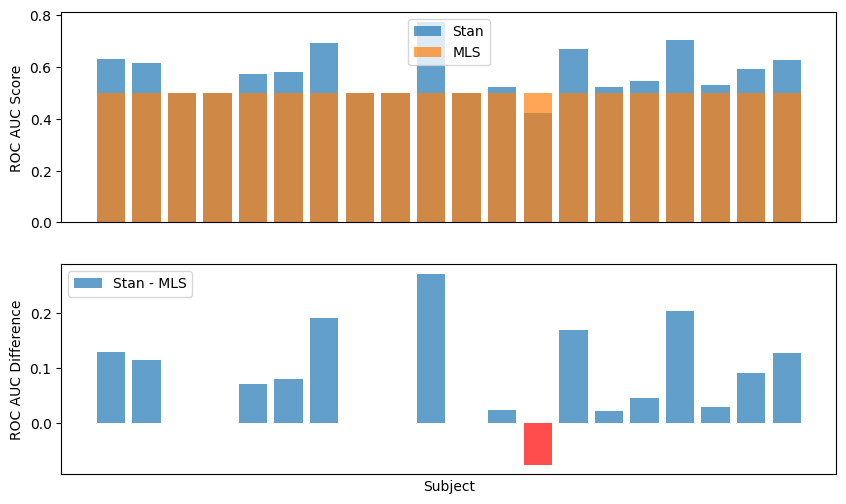

In [62]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.bar(auc_results.index, auc_results['roc_auc_stan'], label='Stan', alpha=0.7)
plt.bar(auc_results.index, auc_results['roc_auc_MLS'], label='MLS', alpha=0.7)
plt.legend()
plt.xticks([], [])  # Remove x axis labels and tick labels
plt.ylabel('ROC AUC Score')

plt.subplot(212)
diff = auc_results['roc_auc_stan'] - auc_results['roc_auc_MLS']
bar_colors = ['red' if auc < 0.5 else 'C0' for auc in auc_results['roc_auc_stan']]
plt.bar(auc_results.index, diff, label='Stan - MLS', alpha=0.7, color=bar_colors)
plt.legend()
plt.xticks([], [])  # Remove x axis labels and tick labels
plt.xlabel('Subject')
plt.ylabel('ROC AUC Difference')

plt.savefig('AUC ROC.png', dpi=300, bbox_inches='tight')

In [ ]:
# how many times auc_results['roc_auc_stan'] or auc_results['roc_auc_MLS'] are <= 0.5
# how many times auc_results['roc_auc_stan'] or auc_results['roc_auc_MLS'] are <= 0.5
num_mls = (auc_results['roc_auc_stan'] <= 0.5).sum()
frac_mls = num_mls / len(auc_results)
print(f"Number of subjects with AUC <= 0.5 for Stan: {num_mls}, fraction: {frac_mls:.2f}")

num_mls = (auc_results['roc_auc_MLS'] <= 0.5).sum()
frac_mls = num_mls / len(auc_results)
print(f"Number of subjects with AUC <= 0.5 for MLS: {num_mls}, fraction: {frac_mls:.2f}")


# how many times # how many times auc_results['roc_auc_stan'] or auc_results['roc_auc_MLS'] are > 0.5 and stan is better than MLS?
num_better = ((auc_results['roc_auc_stan'] > 0.5) & (auc_results['roc_auc_stan'] > auc_results['roc_auc_MLS'])).sum()
frac_better = num_better / len(auc_results)
print(f"Number of subjects with AUC > 0.5 for Stan and better than MLS: {num_better}, fraction: {frac_better:.2f}")

# how many times auc_results['roc_auc_stan'] or auc_results['roc_auc_MLS'] are > 0.5 and MLS is better than Stan?      
num_better = ((auc_results['roc_auc_MLS'] > 0.5) & (auc_results['roc_auc_MLS'] > auc_results['roc_auc_stan'])).sum()
frac_better = num_better / len(auc_results)
print(f"Number of subjects with AUC > 0.5 for MLS and better than Stan: {num_better}, fraction: {frac_better:.2f}")     

Number of subjects with AUC <= 0.5 for Stan: 299, fraction: 0.85
Number of subjects with AUC <= 0.5 for MLS: 329, fraction: 0.94


<Figure size 640x480 with 0 Axes>

Number of subjects with AUC > 0.5 for Stan and better than MLS: 40, fraction: 0.11
Number of subjects with AUC > 0.5 for MLS and better than Stan: 9, fraction: 0.03


In [20]:
params_stan.describe()

params_MLS.describe()

plt.figure(figsize=(10, 6))
params_to_plot = ['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']
# Combine parameters into a long-form DataFrame for grouped boxplots
params_stan_long = params_stan[params_to_plot].melt(var_name='Parameter', value_name='Value')
params_stan_long['Method'] = 'Stan'
params_MLS_long = params_MLS[params_to_plot].melt(var_name='Parameter', value_name='Value')
params_MLS_long['Method'] = 'MLS'
params_long = pd.concat([params_stan_long, params_MLS_long], ignore_index=True)

# Plot grouped boxplots for each parameter

# import seaborn as sns
# sns.violinplot(x='Parameter', y='Value', hue='Method', data=params_long, inner=None, cut=0)
# # Overlay the single point (since all values are the same per method/parameter)
# for i, param in enumerate(params_to_plot):
#     for j, method in enumerate(['Stan', 'MLS']):
#         # Get the unique value for this parameter/method
#         val = params_long[(params_long['Parameter'] == param) & (params_long['Method'] == method)]['Value'].iloc[0]
#         # Offset the x position for Stan and MLS
#         x_pos = i - 0.2 if method == 'Stan' else i + 0.2
#         plt.scatter(x_pos, val, color='k', zorder=10, s=60, marker='o', edgecolor='white')
# plt.ylabel('Parameter Value')
# plt.title('Boxplot of Parameters: Stan vs MLS')
plt.show()

<Figure size 1000x600 with 0 Axes>

In [21]:
params_stan.describe()


,theta,Lambda,alpha,tau,beta,gamma,error
count,350.000000,350.000000,350.000000,350.000000,350.00,350.000000,350.000000
mean,0.270281,1.963745,0.785541,0.259790,0.88,1.009439,-0.117151
std,0.000930,0.023917,0.001229,0.012034,0.00,0.104114,1.657197
min,0.267787,1.908229,0.782355,0.245194,0.88,0.819544,-6.008041
25%,0.269619,1.946772,0.784810,0.254251,0.88,0.931833,-1.178826
50%,0.270302,1.963497,0.785528,0.256800,0.88,0.984401,-0.219486
75%,0.270916,1.982072,0.786333,0.261157,0.88,1.075053,0.929850
max,0.272621,2.025673,0.789345,0.355738,0.88,1.398984,5.535168


/var/folders/73/99zh84sx6gx2kqgq02_rm3zh0000gp/T/ipykernel_17942/1412869040.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data[0], positions=positions - width/2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'), labels=params_to_plot)


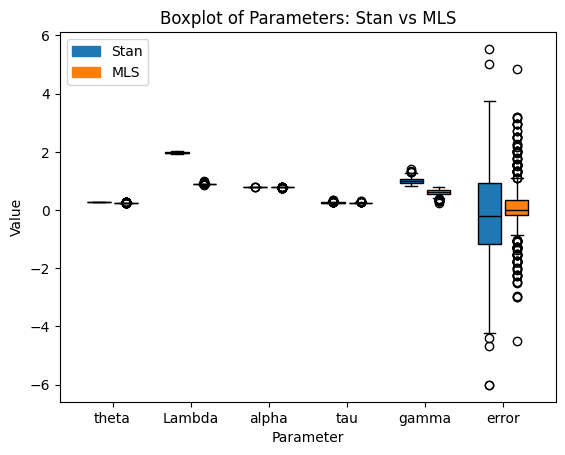

<Figure size 640x480 with 0 Axes>

In [48]:
from matplotlib.patches import Patch

params_to_plot = ['theta', 'Lambda', 'alpha', 'tau', 'gamma', 'error']

# Prepare data for boxplot
data = [
    params_stan[params_to_plot].values,
    params_MLS[params_to_plot].values
]
 
# Create positions for the boxplots
positions = np.arange(len(params_to_plot))
width = 0.35

# Stan boxplots
plt.boxplot(data[0], positions=positions - width/2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='C0'), medianprops=dict(color='black'), labels=params_to_plot)
plt.boxplot(data[1], positions=positions + width/2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='C1'), medianprops=dict(color='black'))
plt.xticks(positions, params_to_plot)

plt.xlabel('Parameter')
plt.ylabel('Value')
plt.title('Boxplot of Parameters: Stan vs MLS')

# Add manual legend
stan_patch = Patch(color='C0', label='Stan')
mls_patch = Patch(color='C1', label='MLS')
plt.legend(handles=[stan_patch, mls_patch])

plt.show()

plt.savefig('boxplot.png', dpi=300, bbox_inches='tight')

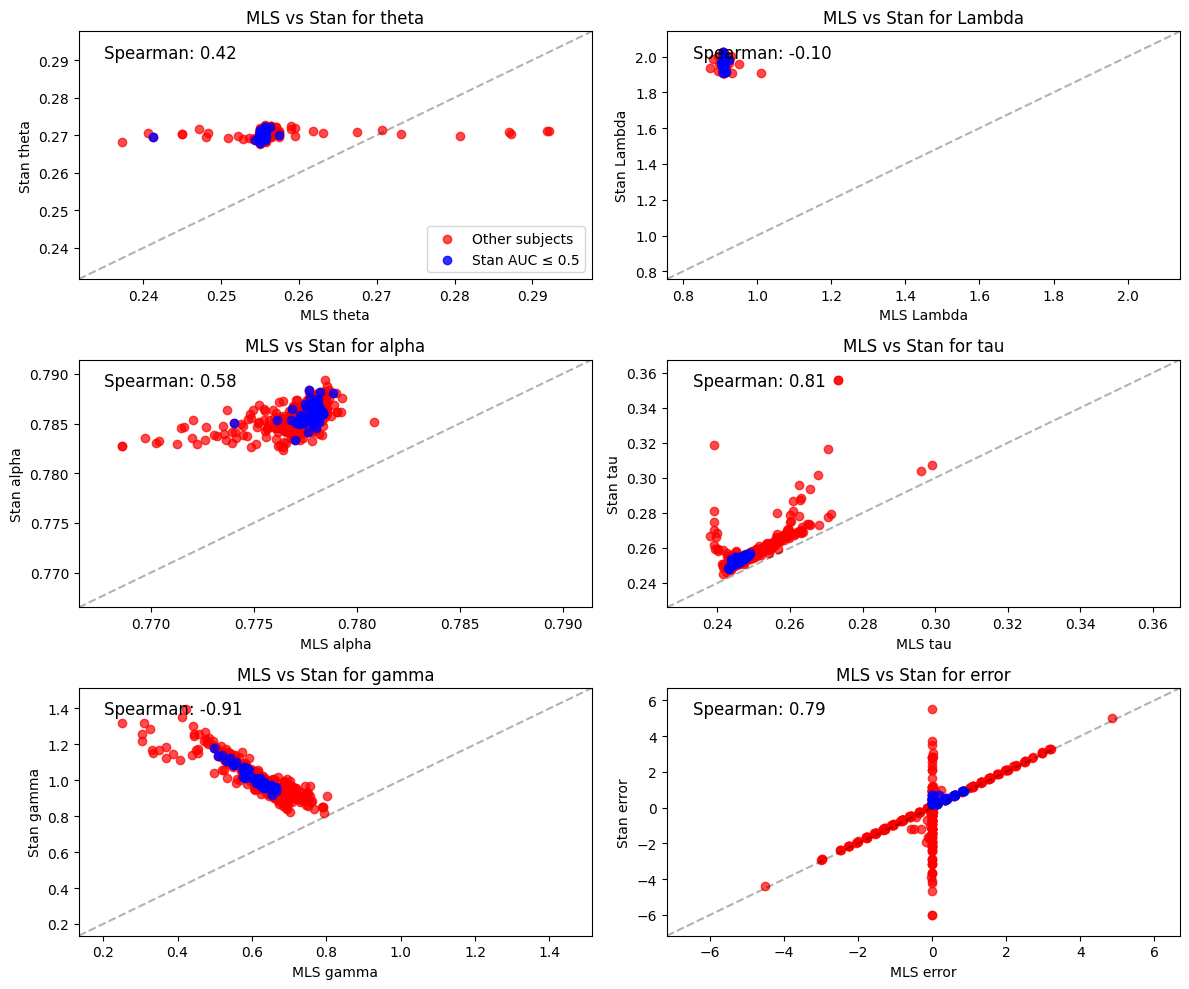

<Figure size 640x480 with 0 Axes>

In [47]:
# Get mask for subjects with Stan AUC <= 0.5
bad_subjects = auc_results.index[auc_results['roc_auc_stan'] > 0.5]

plt.figure(figsize=(12, 10))
for i, param in enumerate(params_to_plot):
    plt.subplot(3, 2, i + 1)
    x = params_stan[param]
    y = params_MLS[param]
    plt.scatter(y, x, alpha=0.7, label='Other subjects', color='red')  # invert axes

    # Highlight in red where Stan AUC <= 0.5
    mask_bad = params_stan['subject'].isin(bad_subjects)
    plt.scatter(y[mask_bad], x[mask_bad], color='blue', alpha=0.8, label='Stan AUC ≤ 0.5')

    plt.xlabel(f'MLS {param}')
    plt.ylabel(f'Stan {param}')
    plt.title(f'MLS vs Stan for {param}')
    
    # Calculate Spearman correlation
    spearman_corr = x.corr(y, method='spearman')
    plt.text(0.05, 0.95, f'Spearman: {spearman_corr:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
    # Set equal axis range with 10% margin
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    data_range = max_val - min_val
    margin = 0.1 * data_range
    plt.xlim(min_val - margin, max_val + margin)
    plt.ylim(min_val - margin, max_val + margin)
    plt.plot([min_val - margin, max_val + margin], [min_val - margin, max_val + margin], 'k--', alpha=0.3)

    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()


plt.savefig('scatter.png', dpi=300, bbox_inches='tight')